# Tohoku tsunami inversion
## 9. Inversion using discrete adjoint with 130 basis functions

Let's modify notebook 5 to use a DG discretisation.

In [1]:
%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import scipy
from time import clock
import os

In [3]:
from thetis import *
from firedrake_adjoint import *
from firedrake.adjoint.blocks import GenericSolveBlock

In [4]:
from adapt_utils.case_studies.tohoku.options import TohokuOptions
from adapt_utils.norms import total_variation
from adapt_utils.misc import gaussian, ellipse, rotation_matrix

_[Misc plotting functions]_

In [5]:
def plot_field(field, figure=None, axes=None, height=5, **kwargs):
    CG1 = field.ufl_element().degree() == 1 and field.ufl_element().family() == 'Lagrange'
    fs_constructor = FunctionSpace if len(field.function_space().shape) == 0 else VectorFunctionSpace
    out = field if CG1 else interpolate(field, fs_constructor(field.function_space().mesh(), "CG", 1))
    
    if figure is None and axes is None:
        figure, axes = plt.subplots(figsize=(height*1.2, height))
    if axes is None:
        axes = plt.gca()
    figure.colorbar(tricontourf(out, levels=50, axes=axes, cmap='coolwarm', **kwargs), ax=axes);
    axes.axis(False);
    axes.set_title(field.dat.name);
    return axes

In [6]:
def plot_fields(*fields, height=5):
    nfields = len(fields)
    fig, axes = plt.subplots(ncols=nfields, figsize=(height*nfields*1.2, height))
    for i, field in enumerate(fields):
        try:
            plot_field(field, fig, axes[i])
        except AttributeError:
            plot_mesh(field, fig, axes[i])
    return axes

In [7]:
level = 0
# level = 1
# level = 2

op = TohokuOptions(level=level)
op.end_time = 24*60.0
# op.end_time = 30*60.0
gauges = list(op.gauges.keys())
for gauge in gauges:
    try:
        op.default_mesh.coordinates.at(op.gauges[gauge]['coords'])
    except PointNotInDomainError:
        op.gauges.pop(gauge)  # Some gauges aren't within the domain
        
mesh = op.default_mesh
R = FunctionSpace(mesh, "R", 0)

boundary_conditions = {
    100: {'un': Constant(0.0), 'elev': 0},
    200: {'un': Constant(0.0)},
    300: {'un': Constant(0.0)},
}

### Forward model

Consider the nonlinear shallow water equations:

$$
    \frac{\partial\mathbf u}{\partial t}
    +\mathbf u\cdot\nabla\mathbf u
    +g\nabla\eta
    +f\widehat{\mathbf z}\times\mathbf u
    =\boldsymbol0,\qquad
    \frac{\partial\eta}{\partial t}
    +\nabla\cdot(H\mathbf u)=0,\qquad
    \text{in}\quad(0,T]\times\Omega,
$$

where $H=\eta+b$.
The shallow water equations are equipped with boundary conditions

$$
    \mathbf u\cdot\widehat{\mathbf n}|_{\Gamma_{\mathrm{freeslip}}}\equiv0,\qquad
    \eta|_{\Gamma_D}\equiv0.
$$

Assume zero initial velocity and expand the initial surface over a radial basis:

$$
    \mathbf u|_{t=0}\equiv\boldsymbol0,\qquad
    \eta|_{t=0}=\sum_{k=1}^N m_kg_k,
$$

where $m_k$ are (constant in space) control parameters and $g_k$ are Gaussians.

In [8]:
basis_region_centre = np.array([0.7e+06, 4.2e+06])
extent_x = 240.0e+03
extent_y = 560.0e+03
Nx = 10
Ny = 13
angle = -pi/12

In [9]:
N = Nx*Ny
basis_centres = []
basis_centres_x = []
basis_centres_y = []
Rtheta = rotation_matrix(angle)
for i in range(Nx):
    basis_centre_x = i*extent_x/(Nx-1) - 0.5*extent_x
    for j in range(Ny):
        basis_centre_y = j*extent_y/(Ny-1) - 0.5*extent_y
        basis_centres_x.append(basis_centre_x)
        basis_centres_y.append(basis_centre_y)
        basis_centres.append(tuple(basis_region_centre + np.dot(Rtheta, np.array([basis_centre_x, basis_centre_y]))))

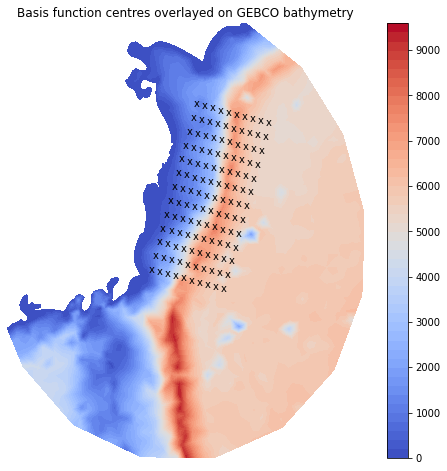

In [10]:
P1 = FunctionSpace(mesh, "CG", 1)
bathymetry_dset = 'gebco'
b = Function(P1, name="Bathymetry (from {:s})".format(bathymetry_dset.upper()))
b.assign(op.set_bathymetry(P1, source=bathymetry_dset))

fig, axes = plt.subplots(figsize=(8, 8))
fig.colorbar(tricontourf(b, axes=axes, cmap='coolwarm', levels=50), ax=axes)
axes.axis('off')
for loc in basis_centres:
    axes.annotate('x', xy=loc)
axes.set_title("Basis function centres overlayed on {:s} bathymetry".format(bathymetry_dset.upper()));

Setup for the initial condition

In [11]:
def get_basis_functions(fs, skew=(24e+03, 48e+03)):
    """
    Define an array of radial basis functions, each of which is a skewed Gaussian. The array is rotated
    about its centre by the (global) `angle` parameter.
    
    :arg fs: the mixed function space in which the initial condition will live.
    :kwarg skew: a tuple describing the extents to which the basis functions are skewed in the rotated axes.
    """
    basis_functions = []
    for loc in basis_centres:
        basis_function = Function(fs)
        psi, phi = basis_function.split()
        phi.interpolate(gaussian([loc + skew, ], fs.mesh(), rotation=angle))
        basis_functions.append(basis_function)
    return basis_functions

In [12]:
def set_basis_coefficients(values):
    """
    Create an array of `Function`s which live in the R-space (of spatial constants) and initialise
    with the provided `values`.
    """
    basis_coefficients = [Function(R) for k in range(N)]
    if isinstance(values, (float, int)):
        values = [values for k in range(N)]
    assert len(values) == N
    for k, val in enumerate(values):
        basis_coefficients[k].assign(val)
    return basis_coefficients

In [13]:
def set_initial_condition(coeffs, fs):
    """
    Construct the propsed initial condition from the basis functions and the proposed coefficients.
    
    Note that if we try and sum all 130 components at once then we get a `maximum recursion depth
    exceeded` error in UFL due to the nested sum. To get around this we just do the sum in two parts.
    
    :arg coeffs: the proposed basis coefficients, expressed as a list.
    :arg fs: the mixed function space in which the initial condition will live.
    """
    basis_functions = get_basis_functions(fs)
    ic = Function(fs)
    tmp = Function(fs)
    ic.project(sum(m*phi for m, phi in zip(coeffs[:N//2], basis_functions[:N//2])))
    tmp.project(sum(m*phi for m, phi in zip(coeffs[N//2:], basis_functions[N//2:])))
    ic.assign(ic + tmp)
    return ic

In [14]:
def get_fields(fs):
    """
    Define fields associated with the physical model, as well as the gravitational acceleration constant.
      
    :arg fs: the mixed function space used to solve the forward problem. The bathymetry and the Coriolis
        parameter are taken to live in the associated elevation space.
    """
    b = Function(fs, name="Bathymetry (from GEBCO)").assign(op.set_bathymetry(fs))
    f = Function(fs, name="Coriolis parameter").assign(op.set_coriolis(fs))
    g = Constant(op.g)  # Gravitational acceleration
    gamma = Constant(0.025)  # Manning drag coefficient
    return b, f, g, gamma

We need an initial guess for the basis coefficients.
Note that radial basis functions don't form an _orthonormal_ (or even orthogonal) basis.
Therefore interpolation isn't straight forward.

In [15]:
saito = op.set_initial_surface(P1)
saito.dat.name = "Initial surface proposed by Saito et al."
initial_guess_values = np.array([float(saito.at(xy)) for xy in basis_centres])
initial_guess_values /= 2

In [16]:
# interpolator = scipy.interpolate.Rbf(basis_centres_x, basis_centres_y, initial_guess_values, function='gaussian', epsilon=48e+03)

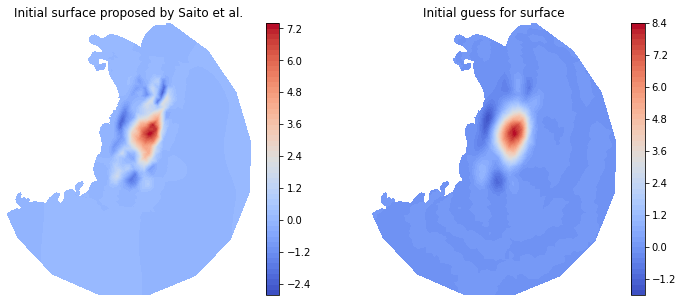

In [17]:
tape = get_working_tape()
tape.clear_tape()
basis_coefficients = set_basis_coefficients(initial_guess_values)
with stop_annotating():
    mixed_space = VectorFunctionSpace(mesh, "DG", 1)*FunctionSpace(mesh, "CG", 2)
    initial_guess = set_initial_condition(basis_coefficients, mixed_space)
    initial_guess_u, initial_guess_eta = initial_guess.split()
    initial_guess_eta.dat.name = "Initial guess for surface"
    plot_fields(saito, initial_guess_eta);

In [18]:
with open('resources/surf/m_init.txt', 'w') as f:
    for mi in initial_guess_values:
        f.write("{:.8e}\n".format(mi))

### Quantity of Interest

Again, we have the QoI

$$
J(\mathbf u,\eta)=\frac12\sum_{g\in\mathcal G}\int_0^T\int_\Omega\mathbb1_g\big(\:\eta(x,t)-\eta_g(t)\:\big)^2\;\mathrm dx\;\mathrm dt,
$$

where $\mathbb1_g$ is an indicator function related to a sufficiently small neighbourhood of gauge $g$.

In [19]:
def sampled_timeseries(g, sample=1):
    time_prev = 0.0
    num_lines = sum(1 for line in open('resources/gauges/{:s}.dat'.format(g), 'r'))
    t, d, running = [], [], []
    with open('resources/gauges/{:s}.dat'.format(g), 'r') as f:
        for i in range(num_lines):
            time, dat = f.readline().split()
            time, dat = float(time), float(dat)
            if np.isnan(dat):
                continue
            running.append(dat)
            if i % sample == 0 and i > 0:
                t.append(0.5*(time + time_prev))
                d.append(np.mean(running))
                running = 0
                time_prev = time
                running = []
                
    interp = scipy.interpolate.interp1d(t, d, bounds_error=False, fill_value='extrapolate')
    init = interp(0.0)
    
    def shifted(tau):
        return interp(tau) - init
    
    return shifted

In [20]:
def solve_forward(m, rotational=False, store_timeseries=False, ext=''):
    """
    Solve the linearised shallow water equations for an array of control parameters, `m`.
    
    :arg m: the array of control parameters, which should have dimension `N`.
    """
    print("FORWARD SOLVE")
    if isinstance(m, Function):
        m = [m, ]
    
    # --- Setup function spaces
    
    P0 = FunctionSpace(mesh, "DG", 0)
    P1 = FunctionSpace(mesh, "CG", 1)
    
    # -- Setup fields
    
    b, f, g, gamma = get_fields(P1)
    
    # --- Setup PDE
    
    solver_obj = solver2d.FlowSolver2d(mesh, b)
    options = solver_obj.options
    options.timestep = op.dt
    options.simulation_end_time = op.end_time
    options.simulation_export_time = 48*op.dt
    options.output_directory = 'outputs/inversion'
    options.timestepper_type = 'CrankNicolson'
    options.element_family = 'dg-cg'
    options.use_lax_friedrichs_velocity = True
    options.lax_friedrichs_velocity_scaling_factor = Constant(1.0)
    options.horizontal_viscosity = None
    if rotational:
        options.coriolis_frequency = f
#     options.manning_drag_coefficient = gamma
    solver_obj.bnd_functions['shallow_water'] = boundary_conditions
    solver_obj.create_function_spaces()
    
    # --- Setup initial condition / control
    
    basis_functions = get_basis_functions(solver_obj.function_spaces.V_2d)
    try:
        assert len(basis_functions) == N
        assert len(m) == N
    except AssertionError:
        msg = "Number of basis functions and number of basis coefficients do not match ({:d} vs {:d})"
        raise ValueError(msg.format(len(basis_functions), len(m)))
        
#     u_init, eta_init = set_initial_condition(m, solver_obj.function_spaces.V_2d).split()
#     solver_obj.assign_initial_conditions(uv=u_init, elev=eta_init)
    if not solver_obj._initialized:
        solver_obj.initialize()
    solver_obj.fields.solution_2d.assign(set_initial_condition(m, solver_obj.function_spaces.V_2d))
    solver_obj.timestepper.initialize(solver_obj.fields.solution_2d)
    
    # --- Setup QoI
    
    radius = 20.0e+03*pow(0.5, level)  # The finer the mesh, the more precise the indicator region
    for gauge in op.gauges:
        op.gauges[gauge]['indicator'] = interpolate(ellipse([op.gauges[gauge]["coords"] + (radius,), ], mesh), P0)
        op.gauges[gauge]['interpolator'] = sampled_timeseries(gauge, sample=1 if gauge[0] == '8' else 60)
        if store_timeseries:
            op.gauges[gauge]['timeseries'+ext] = []
            op.gauges[gauge]['diff'+ext] = []
            op.gauges[gauge]['timeseries_smooth'+ext] = []
            op.gauges[gauge]['diff_smooth'+ext] = []
            op.gauges[gauge]['data'] = []
            op.gauges[gauge]['init'+ext] = None
            op.gauges[gauge]['area'] = assemble(op.gauges[gauge]['indicator']*dx, annotate=False)
    times = []
    op.J = 0
    eta_obs = Constant(0.0)
    weight = Constant(1.0)
    dtc = Constant(op.dt)
    shift = Constant(0.0)
    
    def update_forcings(t):
        times.append(t)
        weight.assign(0.5 if np.allclose(t, 0.0) or np.allclose(t, op.end_time) else 1.0)
        eta = solver_obj.fields.elev_2d
        for gauge in op.gauges:
            
            # Interpolate observations
            obs = float(op.gauges[gauge]['interpolator'](t))
            eta_obs.assign(obs)
            
            if store_timeseries:
                op.gauges[gauge]['data'].append(obs)
                
                # Point evaluation at gauges
                eta_discrete = eta.at(op.gauges[gauge]["coords"])
                if np.allclose(t, 0.0):
                    op.gauges[gauge]['init'+ext] = eta_discrete
                op.gauges[gauge]['timeseries'+ext].append(eta_discrete - op.gauges[gauge]['init'+ext])
                
                # Discrete form of error
                diff = 0.5*(eta_discrete - eta_obs.dat.data[0])**2
                op.gauges[gauge]['diff'+ext].append(diff)

            # Continuous form of error
            I = op.gauges[gauge]['indicator']
            shift.assign(op.gauges[gauge]['init'+ext])
            eta_shift = eta - shift
            diff = 0.5*I*(eta_shift - eta_obs)**2
            op.J += assemble(weight*dtc*diff*dx)
            if store_timeseries:
                A = op.gauges[gauge]['area']
                op.gauges[gauge]['diff_smooth'+ext].append(assemble(diff*dx, annotate=False)/A)
                op.gauges[gauge]['timeseries_smooth'+ext].append(assemble(I*eta_shift*dx, annotate=False)/A)
    
    update_forcings(0.0)
    solver_obj.iterate(update_forcings=update_forcings)
    print("    Quantity of interest = {:.8e}".format(op.J))
    return op.J, solver_obj.fields.solution_2d

In [21]:
def reduced_functional(m, **kwargs):
    J, q = solve_forward(m)
    try:
        controls = [Control(mi) for mi in m]
    except IndexError:
        controls = Control(m)
    return ReducedFunctional(J, controls, **kwargs)

Let's take a look at the forward solution.

In [22]:
tape = get_working_tape()
tape.clear_tape()
basis_coefficients = set_basis_coefficients(initial_guess_values)

FORWARD SOLVE


Using default SIPG parameters
dt = 5.0
Using time integrator: CrankNicolson
    0     0 T=      0.00 eta norm: 945865.9139 u norm:     0.0000  0.00
    1    48 T=    240.00 eta norm: 700566.8172 u norm: 33676.8360 19.23
    2    96 T=    480.00 eta norm: 574464.0201 u norm: 46870.4272 16.48
    3   144 T=    720.00 eta norm: 626908.8085 u norm: 50717.7815 16.66
    4   192 T=    960.00 eta norm: 660481.7016 u norm: 58517.3143 16.30
    5   240 T=   1200.00 eta norm: 663116.3292 u norm: 73350.6924 17.03
    6   288 T=   1440.00 eta norm: 662364.0369 u norm: 89811.2508 16.46


    Quantity of interest = 1.13169737e+13


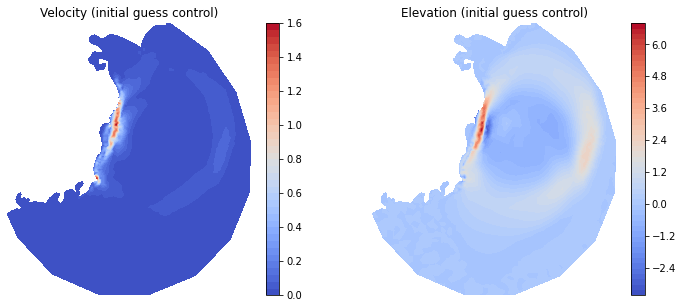

In [23]:
J, q = solve_forward(basis_coefficients, store_timeseries=True)
u, eta = q.split()
u.dat.name = "Velocity (initial guess control)"
eta.dat.name = "Elevation (initial guess control)"
plot_fields(u, eta);

Let's take a look at the adjoint solution.

In [24]:
controls = [Control(m) for m in basis_coefficients]
g = compute_gradient(J, controls)

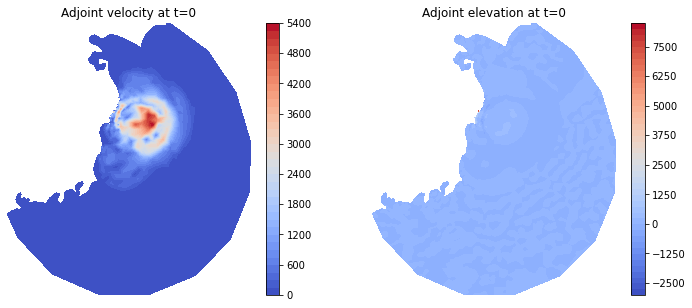

In [31]:
blocks = tape.get_blocks()
solve_blocks = [block for block in blocks if isinstance(block, GenericSolveBlock) and block.adj_sol is not None]
u_star, eta_star = solve_blocks[0].adj_sol.split()
u_star.dat.name = "Adjoint velocity at t=0"
eta_star.dat.name = "Adjoint elevation at t=0"
plot_fields(u_star, eta_star);

## Inversion for 130 basis function coefficients

Now that we have functions for solving the forward problem and computing the gradient, we can apply a quasi-Newton optimisation method such as BFGS to optimise the control parameter.

In [37]:
def derivative_cb_post(j, dj, m):
    gradient_values = np.array([abs(g.dat.data[0]) for g in dj])
    print("functional  {:.8e}  maximum gradient component {:.8e}".format(j, gradient_values.max()))

opt_parameters = {
    'maxiter': 12,
    'gtol': 1.0,
}

tape = get_working_tape()
tape.clear_tape()

# Set initial guesses for controls
parameter_file = 'resources/surf/m_opt.txt'
if not os.path.exists(parameter_file):
    print("Using Saito's initial surface")
    parameter_file = 'resources/surf/m_init.txt'
with open(parameter_file, 'r') as f:
    for i in range(N):
        initial_guess_values[i] = float(f.readline())
m = set_basis_coefficients(initial_guess_values)

# Evaluate the reduced functional
J = reduced_functional(m, derivative_cb_post=derivative_cb_post)

# Call the optimisation routine
m_opt = minimize(J, method='BFGS', options=opt_parameters)

FORWARD SOLVE


Using default SIPG parameters
dt = 5.0
Using time integrator: CrankNicolson
    0     0 T=      0.00 eta norm: 1185427.1185 u norm:     0.0000  0.00
    1    48 T=    240.00 eta norm: 924911.1259 u norm: 58407.0500 18.84
    2    96 T=    480.00 eta norm: 762523.1875 u norm: 83011.6336 16.40
    3   144 T=    720.00 eta norm: 729330.6816 u norm: 106419.4876 16.14
    4   192 T=    960.00 eta norm: 785868.9918 u norm: 129361.9614 15.11
    5   240 T=   1200.00 eta norm: 831868.5522 u norm: 154493.6132 16.09
    6   288 T=   1440.00 eta norm: 829492.0432 u norm: 185981.6762 15.34


    Quantity of interest = 5.57276052e+12
functional  5.57276055e+12  maximum gradient component 2.24730381e+11
functional  5.01116596e+12  maximum gradient component 1.25915844e+11
functional  5.47971094e+12  maximum gradient component 5.52096501e+11
functional  4.81056094e+12  maximum gradient component 1.69924871e+11
functional  4.76139973e+12  maximum gradient component 2.55230042e+11
functional  4.68467068e+12  maximum gradient component 1.71500940e+11
functional  4.59431599e+12  maximum gradient component 2.48719966e+11
functional  4.57573725e+12  maximum gradient component 2.25894734e+11
functional  4.54759327e+12  maximum gradient component 2.09995941e+11
functional  4.52314681e+12  maximum gradient component 2.16827056e+11
functional  4.52619003e+12  maximum gradient component 2.24268760e+11
functional  4.51151841e+12  maximum gradient component 2.20331516e+11
functional  4.49819318e+12  maximum gradient component 2.24308171e+11
functional  4.48363068e+12  maximum gradient com

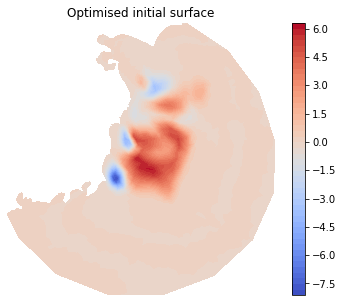

In [39]:
with stop_annotating():
    mixed_space = VectorFunctionSpace(mesh, "DG", 1)*FunctionSpace(mesh, "CG", 2)
    ic_opt = set_initial_condition(m_opt, mixed_space)
    ic_opt_u, ic_opt_eta = ic_opt.split()
    ic_opt_eta.dat.name = "Optimised initial surface"
    plot_field(ic_opt_eta);

In [40]:
with open('resources/surf/m_opt.txt', 'w') as f:
    for mi in m_opt:
        f.write("{:.8e}\n".format(mi.dat.data[0]))

FORWARD SOLVE


Using default SIPG parameters
dt = 5.0
Using time integrator: CrankNicolson
    0     0 T=      0.00 eta norm: 1262353.3189 u norm:     0.0000  0.00
    1    48 T=    240.00 eta norm: 982151.8931 u norm: 62175.6947 19.85
    2    96 T=    480.00 eta norm: 794184.0258 u norm: 86941.0584 16.70
    3   144 T=    720.00 eta norm: 789644.7655 u norm: 107374.8048 17.78
    4   192 T=    960.00 eta norm: 843990.2886 u norm: 129290.8821 16.53
    5   240 T=   1200.00 eta norm: 881605.8980 u norm: 156005.2854 16.46
    6   288 T=   1440.00 eta norm: 881540.4282 u norm: 189681.9576 16.29


    Quantity of interest = 5.02695599e+12


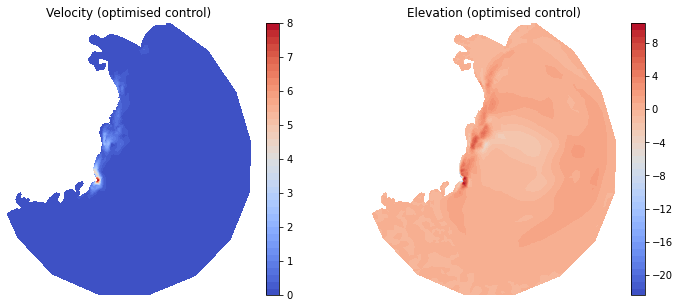

In [41]:
J, q_opt = solve_forward(m_opt, store_timeseries=True, ext='_opt')
u_opt, eta_opt = q_opt.split()
u_opt.dat.name = "Velocity (optimised control)"
eta_opt.dat.name = "Elevation (optimised control)"
plot_fields(u_opt, eta_opt);

/home/joe/software/firedrake-june20/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/joe/software/firedrake-june20/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/joe/software/firedrake-june20/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequ

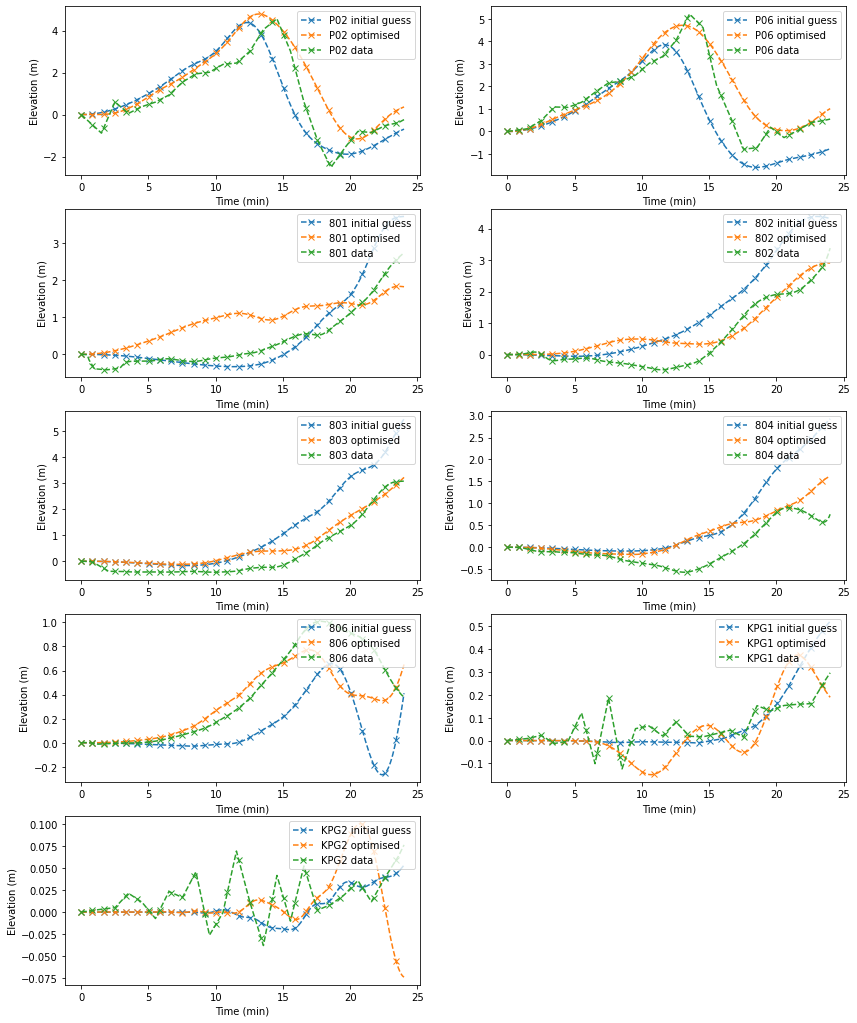

In [44]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 2*len(op.gauges)))

times = np.linspace(0, op.end_time, int(op.end_time/op.dt))
for i, gauge in enumerate(op.gauges):
    ax = axes[i//2, i%2]
#     ax.plot(times/60, op.gauges[gauge]['timeseries_smooth'], '--x', label=gauge + ' initial guess', markevery=10)
#     ax.plot(times/60, op.gauges[gauge]['timeseries_smooth_opt'], '--x', label=gauge + ' optimised', markevery=10)
    ax.plot(times/60, op.gauges[gauge]['timeseries'][:-1], '--x', label=gauge + ' initial guess', markevery=10)
    ax.plot(times/60, op.gauges[gauge]['timeseries_opt'][:-1], '--x', label=gauge + ' optimised', markevery=10)
    ax.plot(times/60, op.gauges[gauge]['data'][:-1], '--x', label=gauge + ' data', markevery=10)
    ax.legend(loc='upper right')
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Elevation (m)')
axes[4, 1].axis('off');

In [45]:
msg = "total variation for gauge {:s}: before {:.4e}  after {:.4e} reduction  {:.1f}%"

print("Continuous")
for gauge in op.gauges:
    tv = total_variation(op.gauges[gauge]['diff_smooth'])
    tv_opt = total_variation(op.gauges[gauge]['diff_smooth_opt'])
    print(msg.format(gauge, tv, tv_opt, 100*(1-tv_opt/tv)))
    
print("\nDiscrete")
for gauge in op.gauges:
    tv = total_variation(op.gauges[gauge]['diff'])
    tv_opt = total_variation(op.gauges[gauge]['diff_opt'])
    print(msg.format(gauge, tv, tv_opt, 100*(1-tv_opt/tv)))

Continuous
total variation for gauge P02: before 1.8874e+01  after 1.3658e+01 reduction  27.6%
total variation for gauge P06: before 1.9820e+01  after 7.6752e+00 reduction  61.3%
total variation for gauge 801: before 2.6458e+00  after 1.5482e+00 reduction  41.5%
total variation for gauge 802: before 2.2452e+00  after 1.1042e+00 reduction  50.8%
total variation for gauge 803: before 4.0949e+00  after 1.0512e+00 reduction  74.3%
total variation for gauge 804: before 2.2017e+00  after 1.1874e+00 reduction  46.1%
total variation for gauge 806: before 7.3372e-01  after 5.6671e-01 reduction  22.8%
total variation for gauge KPG1: before 1.4144e-01  after 1.3945e-01 reduction  1.4%
total variation for gauge KPG2: before 1.7516e-02  after 2.1661e-02 reduction  -23.7%

Discrete
total variation for gauge P02: before 1.2368e+01  after 8.2131e+00 reduction  33.6%
total variation for gauge P06: before 1.5752e+01  after 7.4775e+00 reduction  52.5%
total variation for gauge 801: before 1.3665e+00  aft

We can also compare the instantaneous errors in the free surface approximation over the time period.

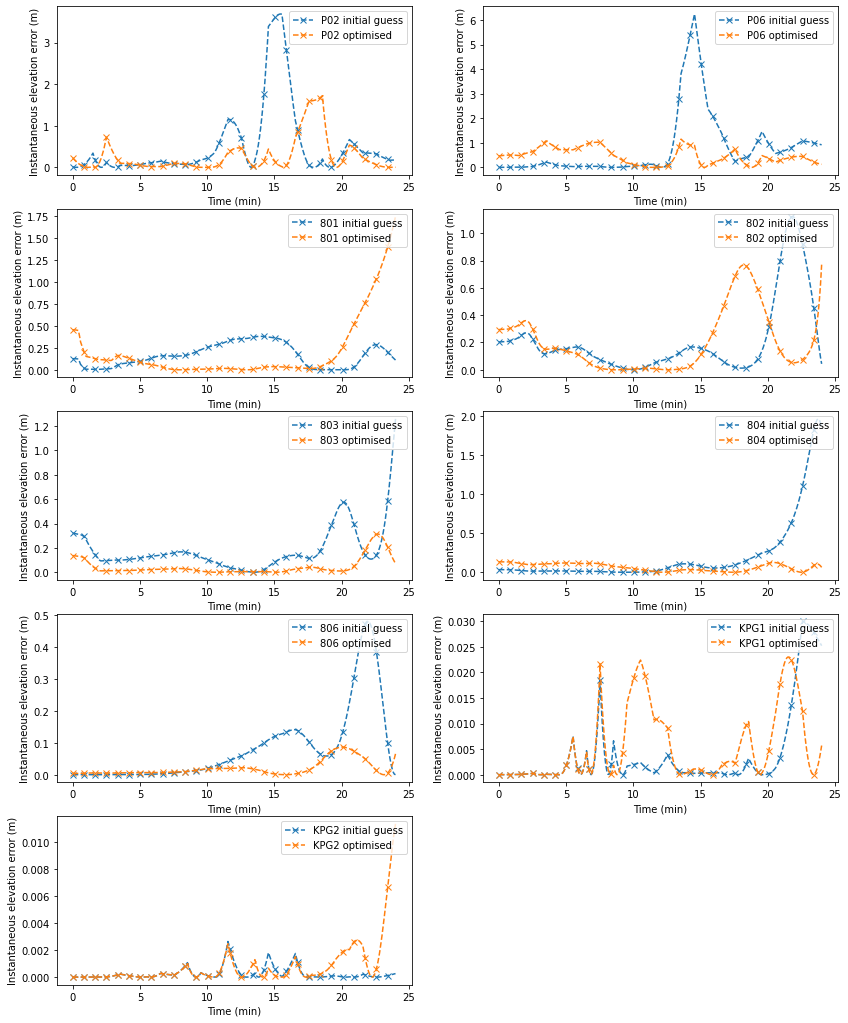

In [46]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 2*len(op.gauges)))

times = np.linspace(0, op.end_time, int(op.end_time/op.dt))
for i, gauge in enumerate(op.gauges):
    ax = axes[i//2, i%2]
#     ax.plot(times/60, op.gauges[gauge]['diff_smooth'], '--x', label=gauge + ' initial guess', markevery=10)
#     ax.plot(times/60, op.gauges[gauge]['diff_smooth_opt'], '--x', label=gauge + ' optimised', markevery=10)
    ax.plot(times/60, op.gauges[gauge]['diff'][:-1], '--x', label=gauge + ' initial guess', markevery=10)
    ax.plot(times/60, op.gauges[gauge]['diff_opt'][:-1], '--x', label=gauge + ' optimised', markevery=10)
    ax.legend(loc='upper right')
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Instantaneous elevation error (m)')
axes[4, 1].axis('off');